<a href="https://colab.research.google.com/github/ArthurMro/Prediction_marketing/blob/master/Prophet_GA_cs_info.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TO TRY:


*   Combine data with Google trends
*   Clarify zone data, zone pred
*   Change shape point
*   X

Based on:
- GA extraction: https://www.youtube.com/watch?v=Xpx--7g6FKk
- Prophet: https://www.youtube.com/watch?v=95-HMzxsghY

In [7]:
from fbprophet import Prophet
import pandas as pd
from apiclient.discovery import build
from oauth2client.service_account import ServiceAccountCredentials
from fbprophet.plot import add_changepoints_to_plot

In [8]:
SCOPES = ['https://www.googleapis.com/auth/analytics.readonly']
KEY_FILE_LOCATION = 'ga-test-api-281612-230ee9ff6b34.json'
VIEW_ID = '193585107' #view cs.info

In [9]:
#Initializing report
def initialize_analyticsreporting():
  credentials = ServiceAccountCredentials.from_json_keyfile_name(
      KEY_FILE_LOCATION, SCOPES)
  analytics = build('analyticsreporting', 'v4', credentials=credentials)
  return analytics

In [10]:
#Get one report page
def get_report(analytics, pageTokenVar):
  return analytics.reports().batchGet(
      body={
        'reportRequests': [
        {
          'viewId': VIEW_ID,
          'dateRanges': [{'startDate': '600daysAgo', 'endDate': 'yesterday'}],
          'metrics': [{'expression': 'ga:sessions'}, {'expression': 'ga:Pageviews'}], #, {'expression': 'ga:Goal completions'} didn't work.
          'dimensions': [{'name': 'ga:Date'}],
          'pageSize': 10000,
          'pageToken': pageTokenVar,
          'samplingLevel': 'LARGE'
        }]
      }
  ).execute()

In [11]:
def handle_report(analytics,pagetoken,rows):  
    response = get_report(analytics, pagetoken)

    #Header, Dimensions Headers, Metric Headers 
    columnHeader = response.get("reports")[0].get('columnHeader', {})
    dimensionHeaders = columnHeader.get('dimensions', [])
    metricHeaders = columnHeader.get('metricHeader', {}).get('metricHeaderEntries', [])

    #Pagination
    pagetoken = response.get("reports")[0].get('nextPageToken', None)
    
    #Rows
    rowsNew = response.get("reports")[0].get('data', {}).get('rows', [])
    rows = rows + rowsNew
    print("len(rows): " + str(len(rows)))

    #Recursivly query next page
    if pagetoken != None:
        return handle_report(analytics,pagetoken,rows)
    else:
        #nicer results
        nicerows=[]
        for row in rows:
            dic={}
            dimensions = row.get('dimensions', [])
            dateRangeValues = row.get('metrics', [])

            for header, dimension in zip(dimensionHeaders, dimensions):
                dic[header] = dimension

            for i, values in enumerate(dateRangeValues):
                for metric, value in zip(metricHeaders, values.get('values')):
                    if ',' in value or ',' in value:
                        dic[metric.get('name')] = float(value)
                    else:
                        dic[metric.get('name')] = int(value)
            nicerows.append(dic)
        return nicerows

In [12]:
#Start
def main():    
    analytics = initialize_analyticsreporting()
    
    global dfanalytics
    dfanalytics = []

    rows = []
    rows = handle_report(analytics,'0',rows)

    dfanalytics = pd.DataFrame(list(rows))


main()

print(dfanalytics)

len(rows): 501
      ga:Date  ga:sessions  ga:Pageviews
0    20190416            5             6
1    20190417            6            19
2    20190418            1             1
3    20190419           11            11
4    20190420            5             6
..        ...          ...           ...
496  20200928           38            54
497  20200929           21            51
498  20200930           24            42
499  20201001           32            54
500  20201002           49            94

[501 rows x 3 columns]


# 2. Prophet

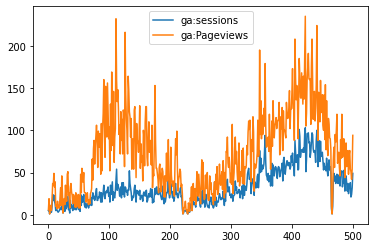

In [13]:
dfanalytics.plot()

## 2.1. Trial one: 300 days

The model seems to have not enough data to perform well when I take only 300 days. Let's see what we get for the trends and seasonality.

Still some conclusion regarding the week trend can be pulled out: Sunday and Monday are our best days. So if we want to even out, we could launch ads for Friday on so on.

## 2.2. Trial two: 600 days

###2.2.1 Train

#### 2.2.1.1 Creating dataset

In [14]:
df2 = dfanalytics

In [15]:
df2['ds'] = pd.to_datetime(df2['ga:Date'])
df2.rename(columns={'ga:sessions': 'y'}, inplace= True)
df2.drop(['ga:Date', 'ga:Pageviews'], axis=1, inplace=True)

print(df2.head())

    y         ds
0   5 2019-04-16
1   6 2019-04-17
2   1 2019-04-18
3  11 2019-04-19
4   5 2019-04-20


#### 2.2.1.2 Removing outliers

From the 27th to the 30th of August included, the data was skewed by a website crash. We will thus replace these values by value in the range of the values around: between 54 and 40, gradually decreasing.

In [16]:
df2.loc[df2.ds == '2020-08-27 00:00:00', 'y'] = 43
df2.loc[df2.ds == '2020-08-28 00:00:00', 'y'] = 40
df2.loc[df2.ds == '2020-08-29 00:00:00', 'y'] = 44
df2.loc[df2.ds == '2020-08-30 00:00:00', 'y'] = 44

In [17]:
df2.tail(30)

,y,ds
471,46,2020-09-03
472,37,2020-09-04
473,44,2020-09-05
474,48,2020-09-06
475,38,2020-09-07
476,37,2020-09-08
477,47,2020-09-09
478,42,2020-09-10
479,34,2020-09-11
480,51,2020-09-12


Second part needs to defer the crash that I got between the 23rd of November and the 28th of December. For that I'll grab back the data from the Google Trends and input a base visitors numbers of 20.

We'll play wild. I took the Google Trends number, clicked the first number of the trends with the last one I had, added a 10 base fix and then sumplemented the soup by adding a random (-3, 3) 

Here is the results: 
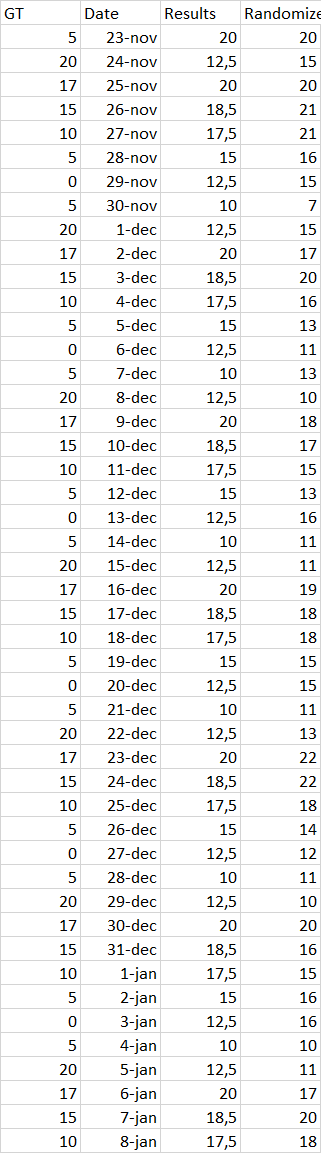


Ok it didn't work by just tranforming the y of certain data, as these dates don't exist. I have to first add some the missing dates to the df.

In [18]:
df2.ds.head()

0   2019-04-16
1   2019-04-17
2   2019-04-18
3   2019-04-19
4   2019-04-20
Name: ds, dtype: datetime64[ns]

In [19]:
missing_dates = pd.date_range(start = '2019-04-16', end = '2019-12-29' ).difference(df2['ds'])
print(missing_dates)

DatetimeIndex(['2019-11-23', '2019-11-24', '2019-11-25', '2019-11-26',
               '2019-11-27', '2019-11-28', '2019-11-30', '2019-12-01',
               '2019-12-02', '2019-12-03', '2019-12-04', '2019-12-05',
               '2019-12-06', '2019-12-07', '2019-12-08', '2019-12-09',
               '2019-12-10', '2019-12-11', '2019-12-12', '2019-12-13',
               '2019-12-14', '2019-12-15', '2019-12-16', '2019-12-17',
               '2019-12-18', '2019-12-19', '2019-12-20', '2019-12-21',
               '2019-12-22', '2019-12-23', '2019-12-24', '2019-12-25',
               '2019-12-26', '2019-12-27'],
              dtype='datetime64[ns]', freq=None)


In [20]:
df_missing_dates = pd.DataFrame(missing_dates)
df_missing_dates.columns = ['ds']
list_replace_values = [20, 15, 20, 21, 21, 16, 7, 15, 17, 20, 16, 13, 11, 13, 10, 18, 17, 15, 13, 16, 11, 11, 19, 18, 18, 15, 15, 22, 21, 11, 13, 9, 7, 4]
df_missing_dates['y'] = list_replace_values

Now I will have to concat and then sort to have a nice df2.

In [21]:
df2 = pd.concat([df2, df_missing_dates])
df2['cap'] = 120
df2['floor'] = 0

In [22]:
df2.sort_values('ds', inplace=True)

Now let's implement this change. Edit: doing it 'by hand' doesn't work. I remove the section.

Second try: didn't work. Seems that we have a problem of data types

In [23]:
df2.reset_index(inplace=True)

In [24]:
df2[200:240]

,index,y,ds,cap,floor
200,200,24,2019-11-02,120,0
201,201,37,2019-11-03,120,0
202,202,27,2019-11-04,120,0
203,203,25,2019-11-05,120,0
204,204,20,2019-11-06,120,0
205,205,28,2019-11-07,120,0
206,206,16,2019-11-08,120,0
207,207,19,2019-11-09,120,0
208,208,35,2019-11-10,120,0
209,209,37,2019-11-11,120,0


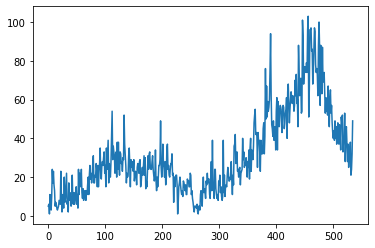

In [25]:
df2['y'].plot()

####2.2.1.3 Tweaking the model

Now while creating the model, we'll tweak some default paramters. Indeed the previous model was clearly underfitting.


*   We'll add seasonality_mode='multiplicative' as parameters, because the seasonality grows in influence
*   changepoint_prior_scale=0.5 to cope with the underfitting. Increasing makes the trends more flexible (so visually broadening the end funnel)
*   A cap of 50k and a floor of 0 in the dataset (just above)
*   yearly.seasonality = 20. It was 10 but I want more


*   List item





In [26]:
model = Prophet(changepoint_prior_scale=0.5, changepoint_range=0.9, seasonality_mode='multiplicative', yearly_seasonality = 10)
model.fit(df2)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [27]:
#Forecasting
future = model.make_future_dataframe(periods= 60)
future['cap'] = 120
future['floor'] = 0
print(future.tail())

            ds  cap  floor
590 2020-11-27  120      0
591 2020-11-28  120      0
592 2020-11-29  120      0
593 2020-11-30  120      0
594 2020-12-01  120      0


In [28]:
forecast = model.predict(future)
forecast.tail()

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
590,2020-11-27,21.696194,120,-0.089812,19.644588,20.391918,22.937216,-0.564616,-0.564616,-0.564616,-0.111287,-0.111287,-0.111287,-0.453329,-0.453329,-0.453329,0.0,0.0,0.0,9.446172
591,2020-11-28,21.542329,120,0.671891,20.050432,20.191195,22.811644,-0.524423,-0.524423,-0.524423,-0.060221,-0.060221,-0.060221,-0.464201,-0.464201,-0.464201,0.0,0.0,0.0,10.245040
592,2020-11-29,21.388464,120,4.147575,23.402936,19.996335,22.692840,-0.365910,-0.365910,-0.365910,0.106544,0.106544,0.106544,-0.472454,-0.472454,-0.472454,0.0,0.0,0.0,13.562216
593,2020-11-30,21.234599,120,3.081586,22.185227,19.798174,22.567181,-0.389110,-0.389110,-0.389110,0.089151,0.089151,0.089151,-0.478261,-0.478261,-0.478261,0.0,0.0,0.0,12.971999
594,2020-12-01,21.080734,120,2.156121,21.486046,19.604855,22.446468,-0.453997,-0.453997,-0.453997,0.027866,0.027866,0.027866,-0.481863,-0.481863,-0.481863,0.0,0.0,0.0,11.510147


In [29]:
forecast.columns

Index(['ds', 'trend', 'cap', 'yhat_lower', 'yhat_upper', 'trend_lower',
       'trend_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'weekly', 'weekly_lower', 'weekly_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'additive_terms',
       'additive_terms_lower', 'additive_terms_upper', 'yhat'],
      dtype='object')

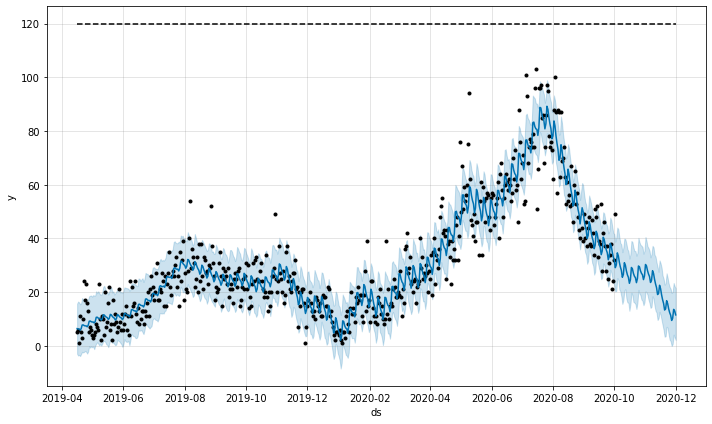

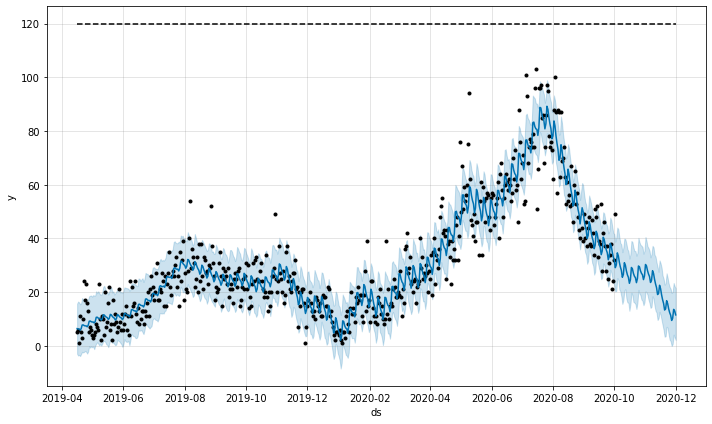

In [30]:
model.plot(forecast)

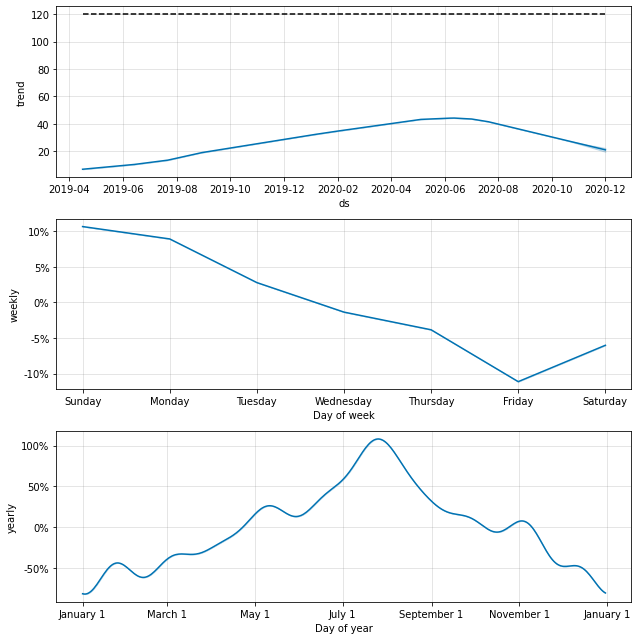

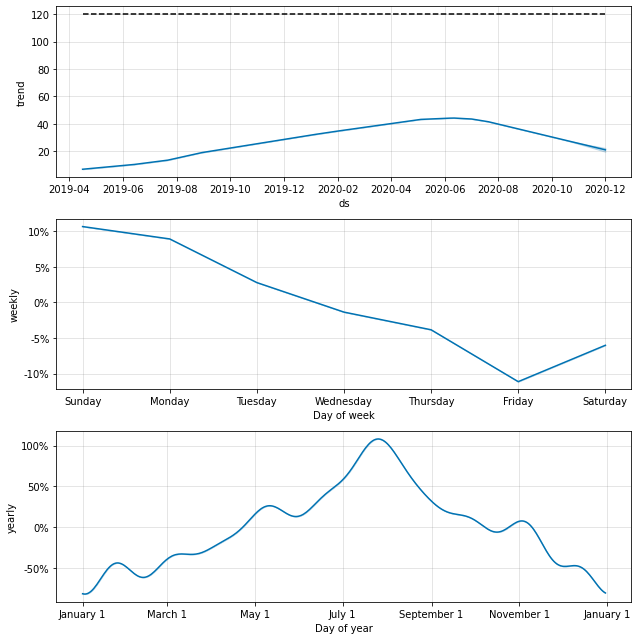

In [31]:
model.plot_components(forecast)

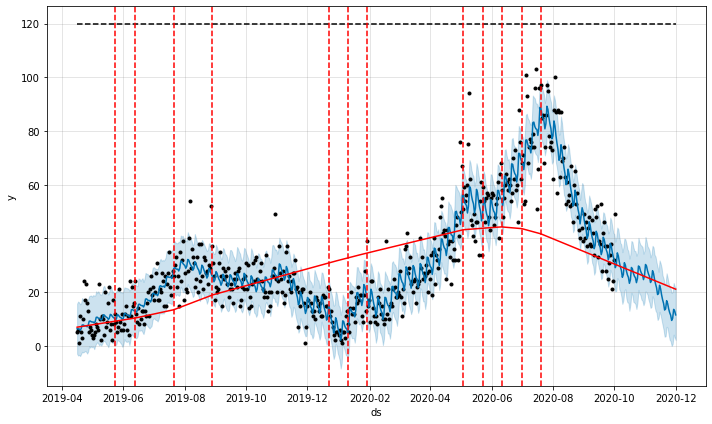

In [32]:
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

### 2.2.2 Test

In [33]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, horizon = '30 days', parallel="processes")
df_cv.head()

INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-04-20 00:00:00 and 2020-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fca338a6d30>


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-04-21,43.656911,35.810977,51.462809,33,2020-04-20
1,2020-04-22,40.172376,32.849949,47.814185,23,2020-04-20
2,2020-04-23,39.619786,31.452612,47.286915,39,2020-04-20
3,2020-04-24,34.311108,27.464258,42.344917,32,2020-04-20
4,2020-04-25,37.004775,29.380996,44.972164,36,2020-04-20


In [34]:
# Performance metrics
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head(20)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days,123.579171,11.116617,8.258047,0.150935,0.081168,0.734483
1,4 days,123.463764,11.111425,8.525002,0.160285,0.089674,0.668966
2,5 days,115.740158,10.758260,8.155172,0.134080,0.108044,0.693103
3,6 days,110.820897,10.527150,8.168023,0.137299,0.117717,0.672414
4,7 days,122.630608,11.073871,7.966795,0.136462,0.096043,0.700000
5,8 days,158.110386,12.574195,9.530849,0.182053,0.112772,0.593103
6,9 days,210.761132,14.517615,11.721243,0.225806,0.195738,0.462069
7,10 days,218.121359,14.768932,12.908491,0.244076,0.196821,0.365517
8,11 days,330.271831,18.173382,15.714433,0.281456,0.203649,0.275862
9,12 days,385.035230,19.622315,17.190705,0.307939,0.291721,0.172414


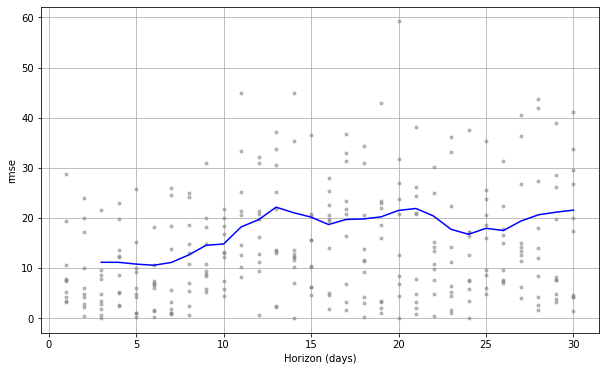

In [35]:
# Visualizing the performance metrics
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')

Final step: savign the forecast as txt. That's for the sake of the visualization.

In [36]:
forecast[['ds', 'yhat']].to_csv('forecast.txt',index=False, header=False)

#3. Animation

It's time to make a funny graphical animation of the plot.
I followed the tutorial here: https://towardsdatascience.com/animations-with-matplotlib-d96375c5442c
https://www.youtube.com/watch?v=ZmYPzESC5YY
https://medium.com/datadriveninvestor/time-series-animation-in-matplotlib-de023655a197

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from matplotlib import style
from datetime import datetime
from matplotlib.animation import FuncAnimation, PillowWriter
%matplotlib inline

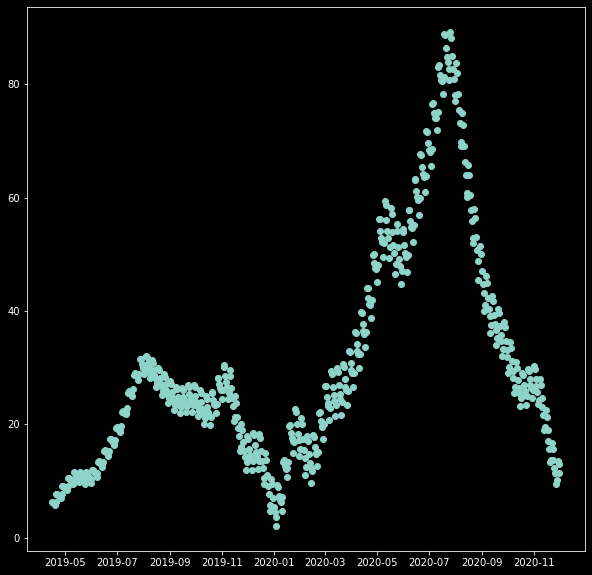

In [38]:
with plt.style.context('dark_background'):
    fig = plt.figure(figsize=(10,10))
    plt.subplot(1,1,1)
    plt.plot(forecast['ds'], forecast['yhat'], linewidth=0,marker="o")

In [39]:
forecast.head()

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2019-04-16,6.926927,120,-3.022311,15.734283,6.926927,6.926927,-0.076721,-0.076721,-0.076721,0.027866,0.027866,0.027866,-0.104587,-0.104587,-0.104587,0.0,0.0,0.0,6.395486
1,2019-04-17,6.985021,120,-3.647258,16.493058,6.985021,6.985021,-0.105934,-0.105934,-0.105934,-0.013614,-0.013614,-0.013614,-0.092321,-0.092321,-0.092321,0.0,0.0,0.0,6.245067
2,2019-04-18,7.043114,120,-3.389124,16.166280,7.043114,7.043114,-0.117782,-0.117782,-0.117782,-0.038439,-0.038439,-0.038439,-0.079343,-0.079343,-0.079343,0.0,0.0,0.0,6.213560
3,2019-04-19,7.101207,120,-3.850514,15.438412,7.101207,7.101207,-0.176876,-0.176876,-0.176876,-0.111287,-0.111287,-0.111287,-0.065589,-0.065589,-0.065589,0.0,0.0,0.0,5.845175
4,2019-04-20,7.159300,120,-3.001433,15.823389,7.159300,7.159300,-0.111234,-0.111234,-0.111234,-0.060221,-0.060221,-0.060221,-0.051012,-0.051012,-0.051012,0.0,0.0,0.0,6.362946


##3.1 Creating the frame

In [40]:
df3 = forecast.merge(df2, on='ds', how = 'left')

In [41]:
df3.tail()

,ds,trend,cap_x,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,index,y,cap_y,floor
590,2020-11-27,21.696194,120,-0.089812,19.644588,20.391918,22.937216,-0.564616,-0.564616,-0.564616,-0.111287,-0.111287,-0.111287,-0.453329,-0.453329,-0.453329,0.0,0.0,0.0,9.446172,NaN,NaN,NaN,NaN
591,2020-11-28,21.542329,120,0.671891,20.050432,20.191195,22.811644,-0.524423,-0.524423,-0.524423,-0.060221,-0.060221,-0.060221,-0.464201,-0.464201,-0.464201,0.0,0.0,0.0,10.245040,NaN,NaN,NaN,NaN
592,2020-11-29,21.388464,120,4.147575,23.402936,19.996335,22.692840,-0.365910,-0.365910,-0.365910,0.106544,0.106544,0.106544,-0.472454,-0.472454,-0.472454,0.0,0.0,0.0,13.562216,NaN,NaN,NaN,NaN
593,2020-11-30,21.234599,120,3.081586,22.185227,19.798174,22.567181,-0.389110,-0.389110,-0.389110,0.089151,0.089151,0.089151,-0.478261,-0.478261,-0.478261,0.0,0.0,0.0,12.971999,NaN,NaN,NaN,NaN
594,2020-12-01,21.080734,120,2.156121,21.486046,19.604855,22.446468,-0.453997,-0.453997,-0.453997,0.027866,0.027866,0.027866,-0.481863,-0.481863,-0.481863,0.0,0.0,0.0,11.510147,NaN,NaN,NaN,NaN


This next paragraph was a pain. I had to download the video each time I wanted feedback.
For GIF everyone suggest Imagemagick with I can't install. So I try now with Pillowriter. FFmepg was only giving me mp4.

Now, that I could get the GIF, I need to only animate a part of my graph: the prediction.

I forgot to add the labels and titles and it's quite a pain, they never appears and I don't where to place the lines of code.
Now I understood that what I put at the beginning, in the "with" appears in my jupiter and what in put in the "def animate" appears in the gif. But one info doesn't ever appears on both.

Putaiiiiiiiin, maintenant se sont mes axes qui ont disparus. Et les labels qui sont jamais apparus.

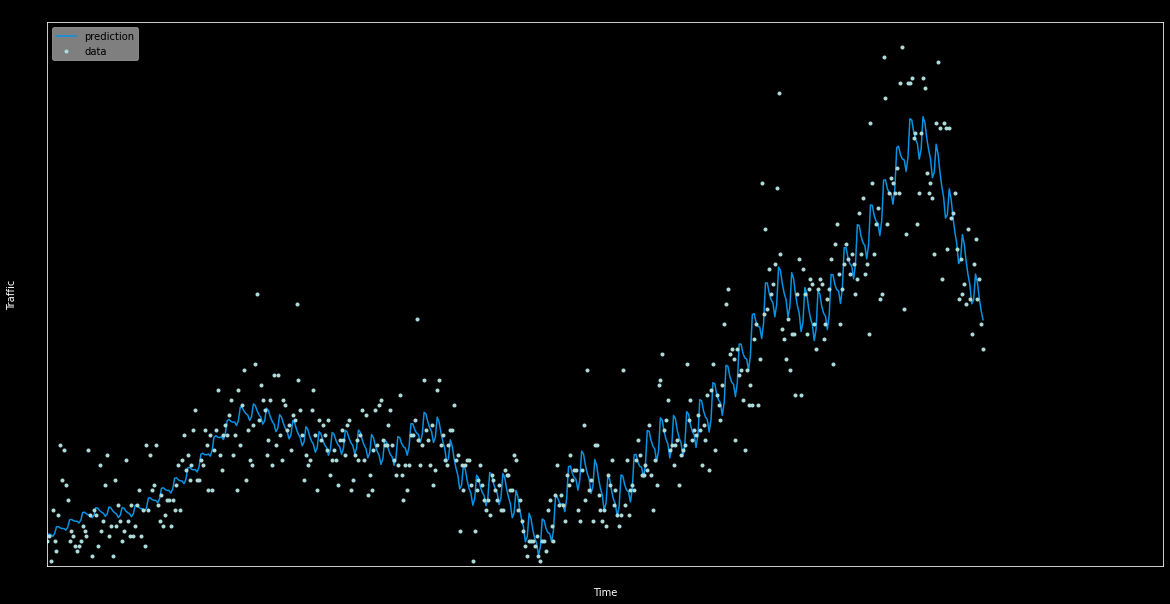

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


In [57]:
with plt.style.context('dark_background'):
    fig = plt.figure(figsize=(20,10))
    #creating a subplot 
    ax1 = fig.add_subplot(1,1,1)




    def animate(i):

        lines =  df3.iloc[0:int(i+500)] #   set the variable data to contain 0 to the (i+1)th row. I wanted only the prediction, so put 535.
        xs = []                         # Fakinel! I don't understand why but if I put  df3.iloc[0:int(i+535)] with a zero starting point, it understands EXACTLY what I want!
        ys = []
        zs = []
        for line in lines:
            if len(line)>1:
                xs = lines['ds']
                ys = lines['yhat']
                zs = lines['y']

        ax1.clear()
        
        ax1.set(title='Predicting the future traffic of my website',xlabel= "Time", ylabel='Traffic')
        ax1.axis(xmin= (df3['ds'].min()), xmax=(df3['ds'].max())) #XX I should add margin here too.
        ax1.axis(ymin= (df3['y'].min()-1), ymax=(df3['y'].max()+5)) #adding a bit of margin with -1 and +5

        ax1.plot(xs, ys, label='prediction', color='#0693e3')
        ax1.plot(xs, zs, marker = '.' ,linewidth = 0.0, label='data', color='#afdedc') #linewidth is not visible at 0.1, I change to 0.3
        ax1.legend(loc='upper left', frameon=True, framealpha = 0.5 )
        



writergif = animation.PillowWriter(fps=30) 

ani = animation.FuncAnimation(fig, animate, frames = (len(forecast)-len(df2)+30), interval=10) #the amount of frames had to be changed quite a lot to make a stop at the end.

plt.show()

writergif = animation.PillowWriter(fps=30, metadata=dict(artist='Arthur_Moreau')) 
ani.save('animation_video.gif', writer=writergif)